<a href="https://colab.research.google.com/github/PermanAtayev/Movie-revenue-prediction/blob/master/movie_revenue_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import seaborn as sns
import ast
import lightgbm as lgb
import xgboost as xgb

import requests
from io import BytesIO

from PIL import Image

import eli5


import catboost

import urllib

from wordcloud import WordCloud
from collections import Counter
from sklearn import feature_extraction
from sklearn import preprocessing
from datetime import datetime
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from keras import layers
from keras import models
from sklearn.preprocessing import LabelEncoder
from keras import regularizers
from keras.metrics import mean_squared_logarithmic_error
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}

matplotlib.rc('font', **font)


# Data

In [87]:
train=pd.read_csv('/kaggle/input/data-movie-revenue/train.csv')

print(train.shape)

(3000, 23)


In [ ]:
train.info()

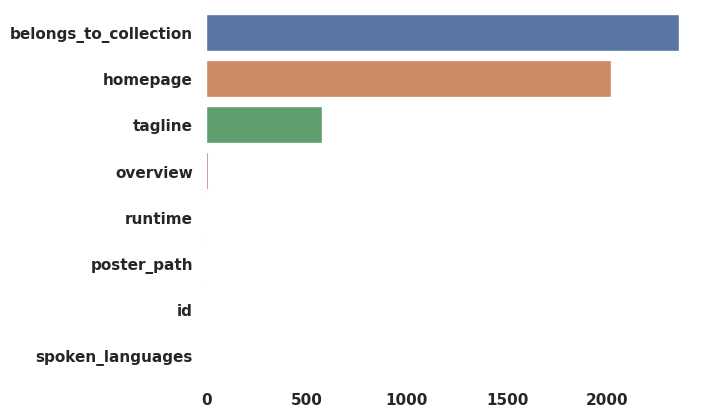

In [116]:
missing=train.isna().sum().sort_values(ascending=False)
sns.barplot(x=missing[:8],y=missing[:8].index)
plt.style.use('dark_background')
plt.show()

In [94]:
dict_columns = [ 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew',]

def text_to_dict(df):
    for column in dict_columns:
        print(column)
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    return df
        
dfx = text_to_dict(train)
for col in dict_columns:
       train[col]=dfx[col]

genres
production_companies
production_countries
spoken_languages
Keywords
cast
crew


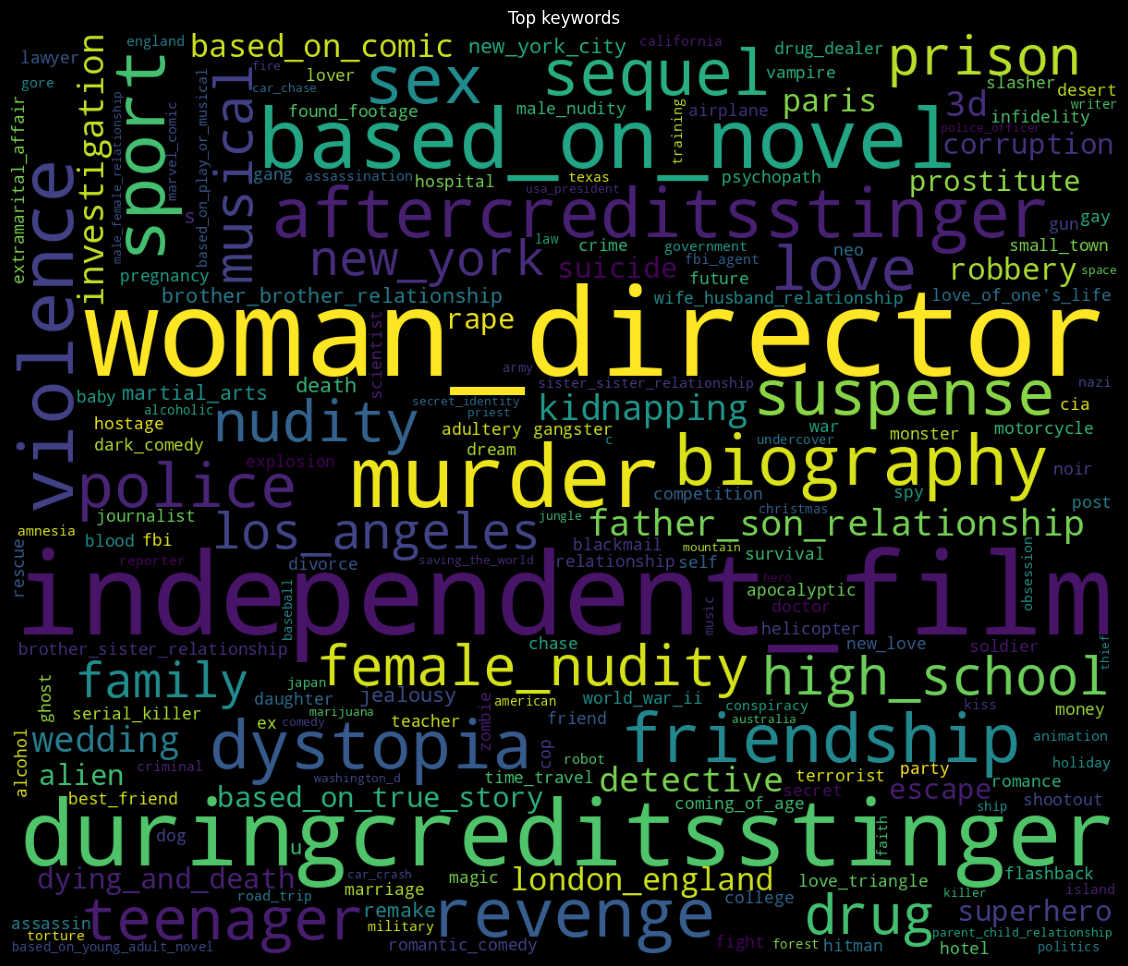

In [117]:
list_of_keywords = list(train['Keywords'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
plt.figure(figsize = (16, 12))
text = ' '.join(['_'.join(i.split(' ')) for j in list_of_keywords for i in j])
wordcloud = WordCloud(max_font_size=None, background_color='black', collocations=False,
                      width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top keywords')
plt.axis("off")
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


<Axes: >

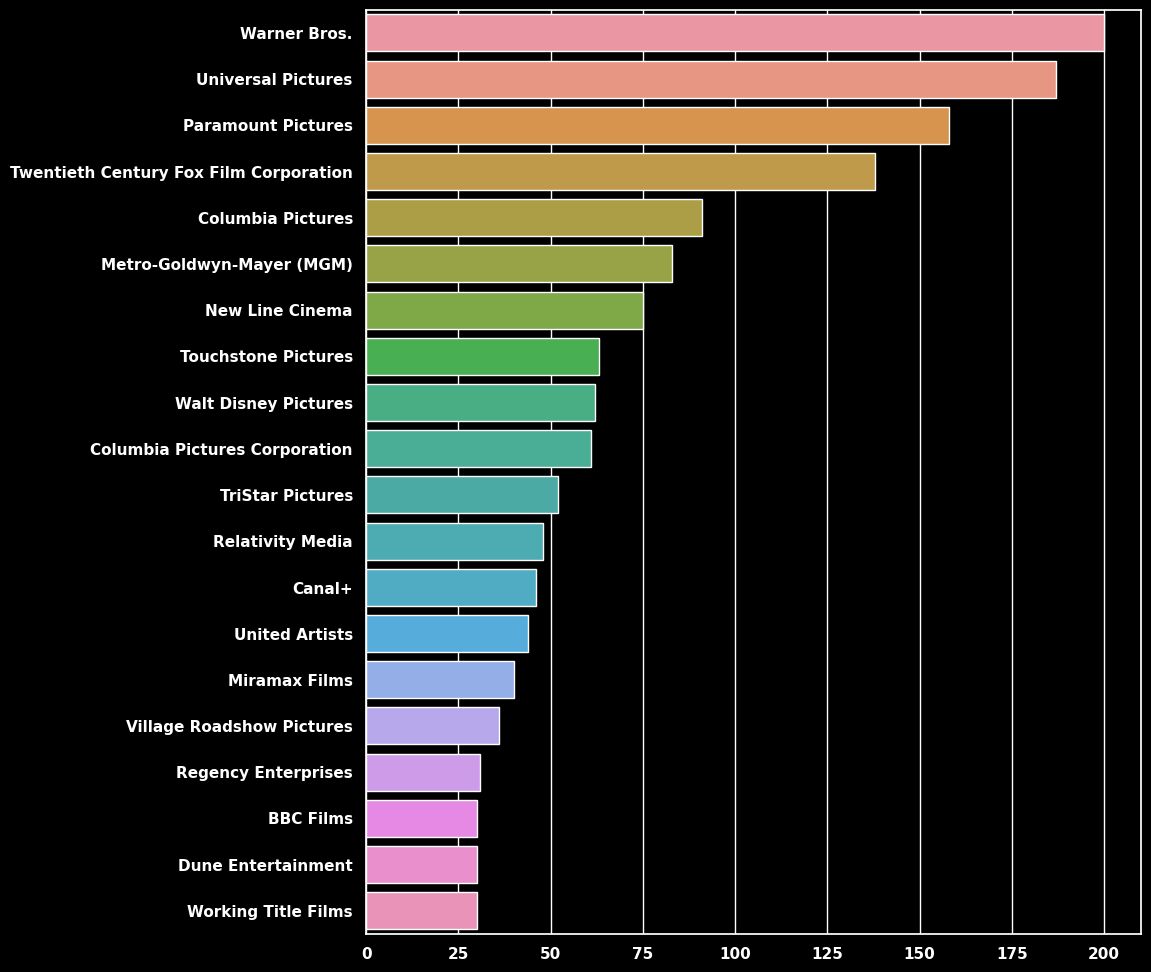

In [118]:
x=train['production_companies'].apply(lambda x : [x[i]['name'] for i in range(len(x))] if x != {} else []).values
count=Counter([i for j in x for i in j]).most_common(20)
plt.figure(figsize=(10,12))
sns.barplot(x=[val[1] for val in count],y=[val[0] for val in count])

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


<Axes: >

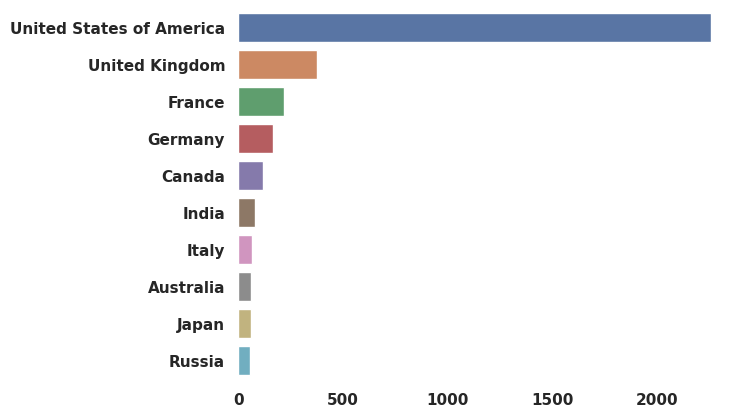

In [114]:
countries=train['production_countries'].apply(lambda x: [i['name'] for i in x] if x!={} else []).values
count=Counter([j for i in countries for j in i]).most_common(10)
sns.barplot(x=[val[1] for val in count],y=[val[0] for val in count])

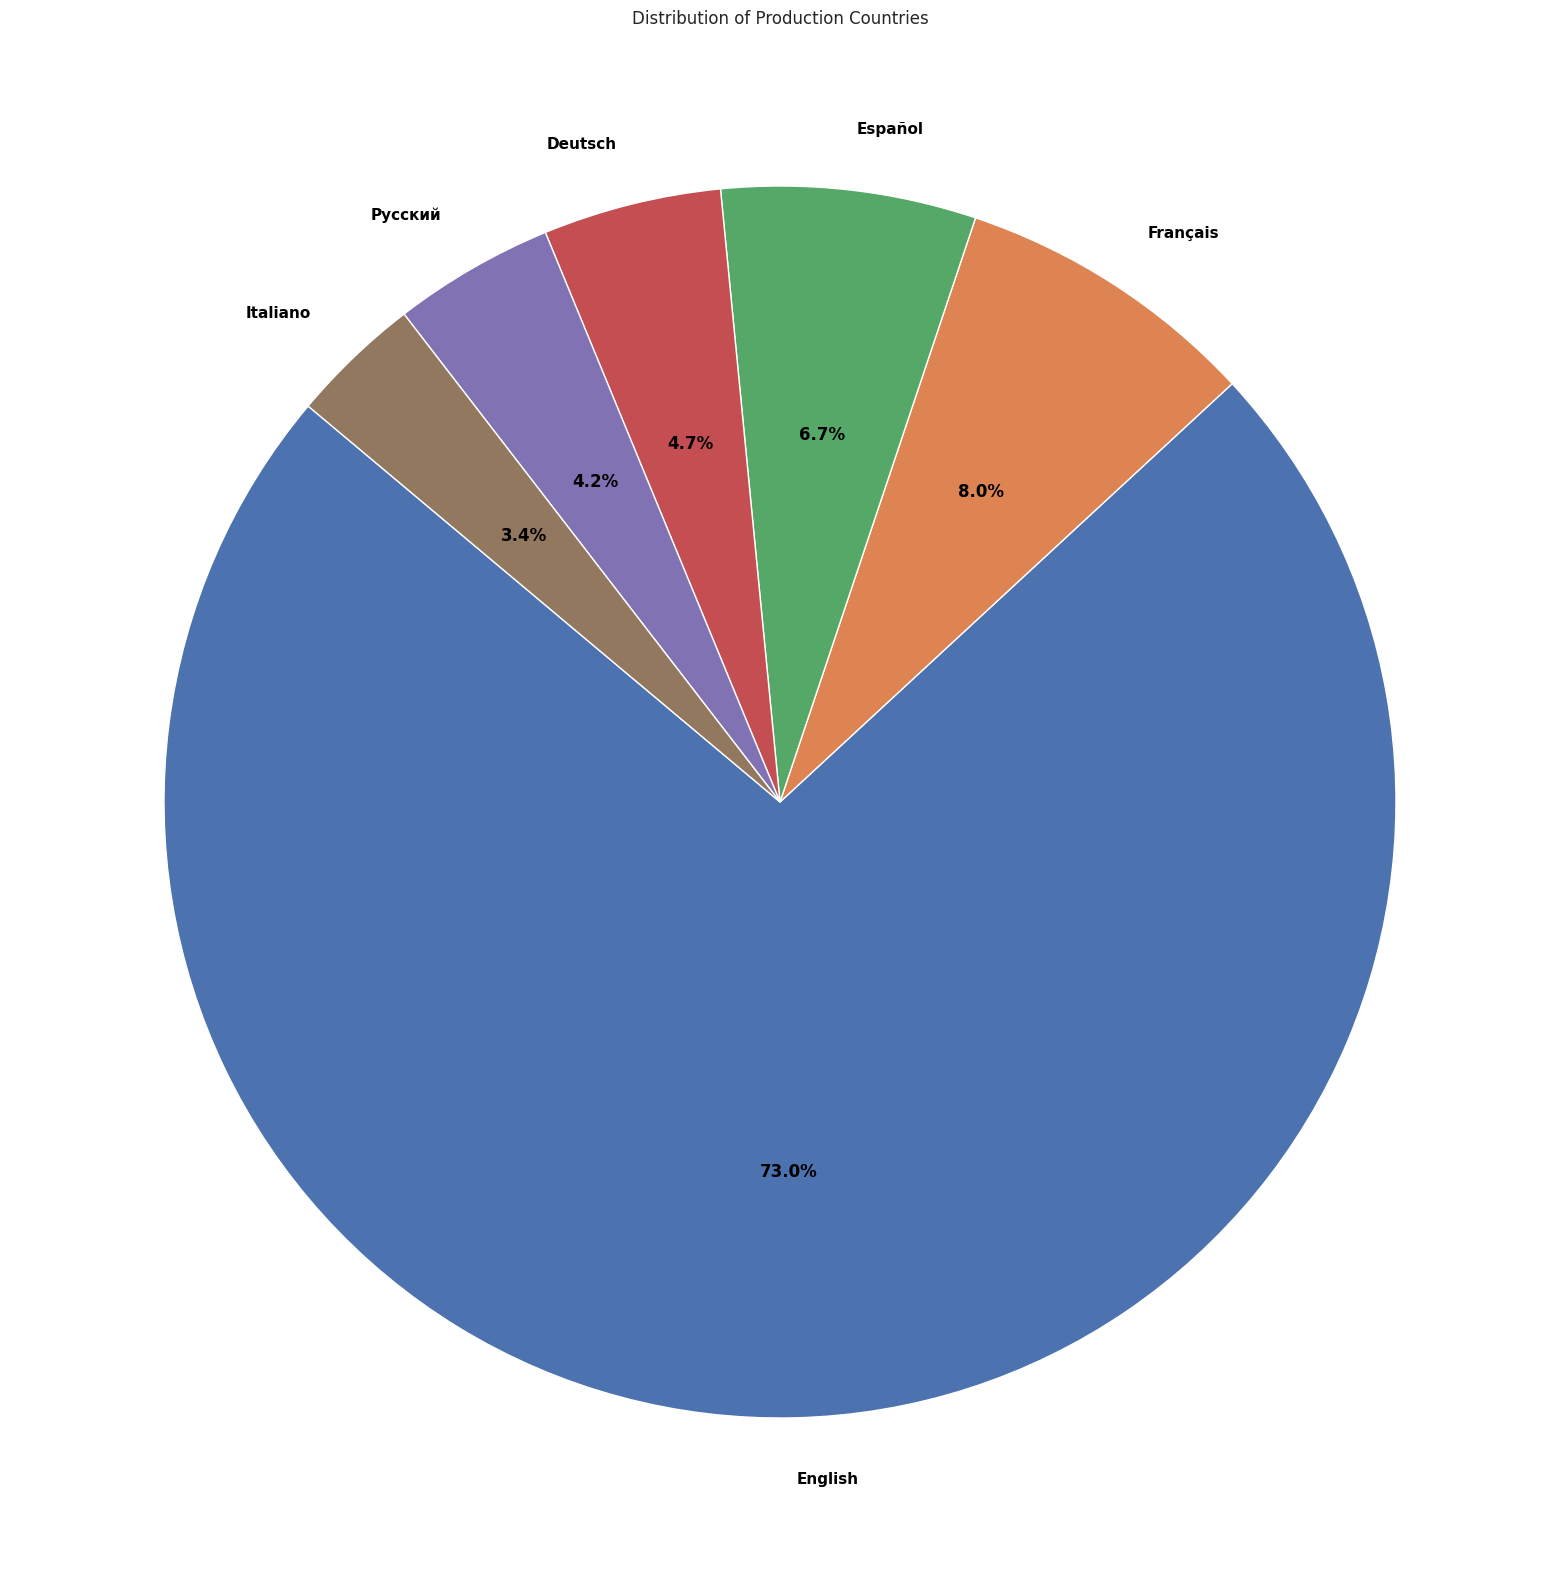

In [113]:
# Convert the list to a DataFrame
df = pd.DataFrame(count, columns=['Country', 'Count'])

# Set up the pie chart
plt.figure(figsize=(20, 20), facecolor = 'white')
plt.pie(df['Count'], labels=df['Country'], autopct='%1.1f%%', startangle=140,  textprops={'color': 'black'})

# Add a title
plt.title('Distribution of Production Countries')

# Show the pie chart
plt.show()

In [112]:
train['spoken_languages'].apply(lambda x:len(x) if x !={} else 0).value_counts()

spoken_languages
1    2071
2     543
3     214
4      72
5      23
0      18
7       6
6       5
8       2
9       1
Name: count, dtype: int64

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


<Axes: >

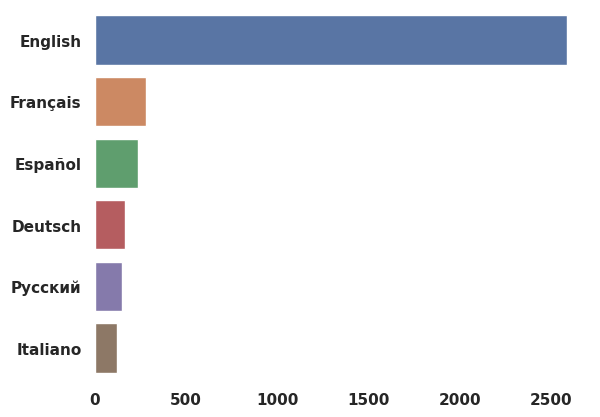

In [111]:
lang=train['spoken_languages'].apply(lambda x: [i['name'] for i in x] if x != {} else [])
count=Counter([i for j in lang for i in j]).most_common(6)
sns.barplot(x=[val[1] for val in count],y=[val[0] for val in count])

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


<Axes: >

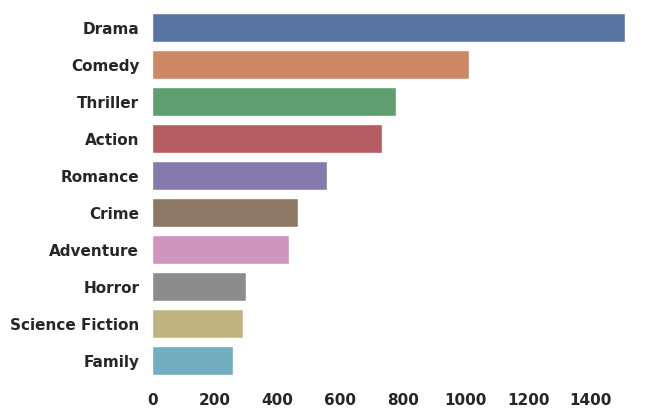

In [110]:
genre=train['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else [])
count=Counter([i for j in genre for i in j]).most_common(10)
sns.barplot(x=[val[1] for val in count],y=[val[0] for val in count])

In [ ]:
train['revenue'].describe()

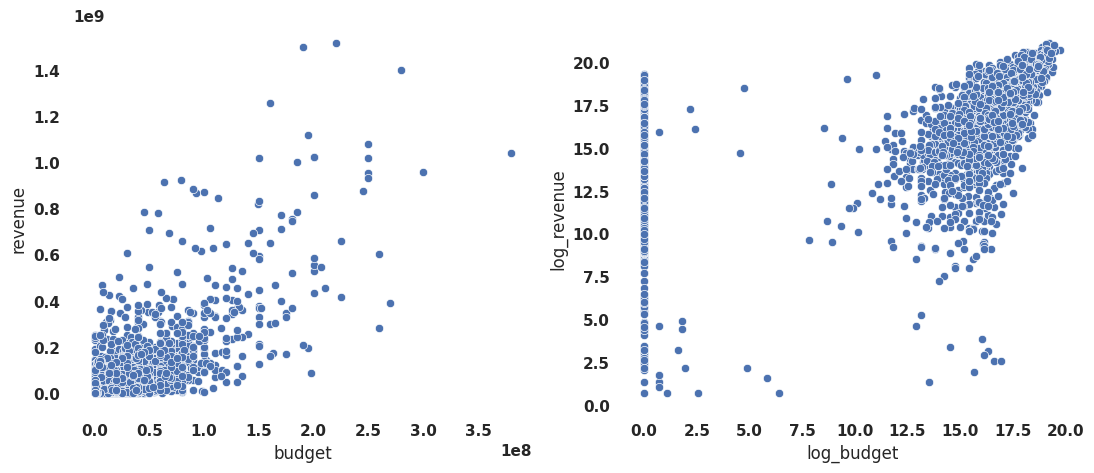

In [68]:
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
sns.scatterplot(x=train['budget'],y=train['revenue'])
plt.subplot(1,2,2)
plt.xlabel('log_budget')
plt.ylabel('log_revenue')
sns.scatterplot(x=np.log1p(train['budget']),y=np.log1p(train['revenue']))
plt.show()

/tmp/ipykernel_33/2913972558.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train['revenue'], shade=True)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


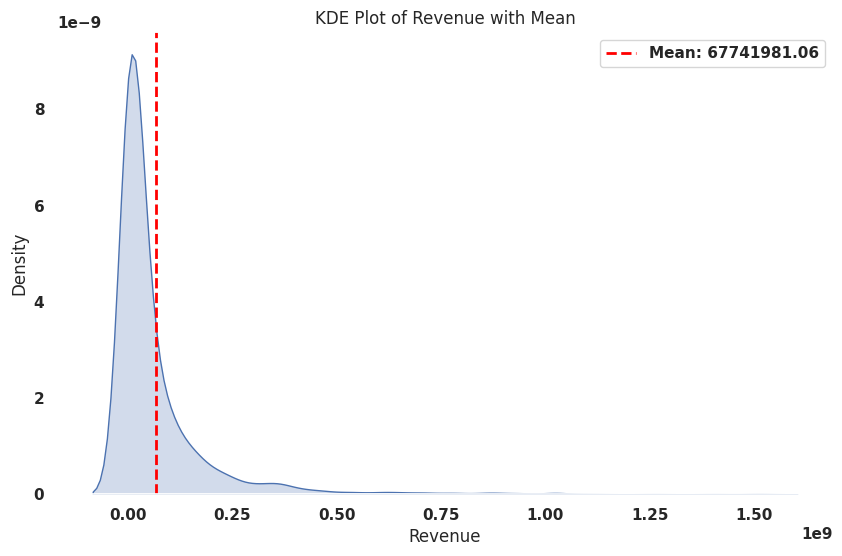

In [83]:
mean_revenue = train['revenue'].mean()
# Set up the plot
# sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
plt.figure(figsize=(10, 6))

# Plot the KDE for the 'revenue' column
sns.kdeplot(train['revenue'], shade=True)

# Add a vertical line at the mean
plt.axvline(mean_revenue, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_revenue:.2f}')

# Add labels and title
plt.title('KDE Plot of Revenue with Mean')
plt.xlabel('Revenue')
plt.ylabel('Density')
plt.legend()

# Show the plot
plt.show()

In [106]:
train['log_revenue']=np.log1p(train['revenue'])

/tmp/ipykernel_33/2615132665.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train['log_revenue'], shade=True)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


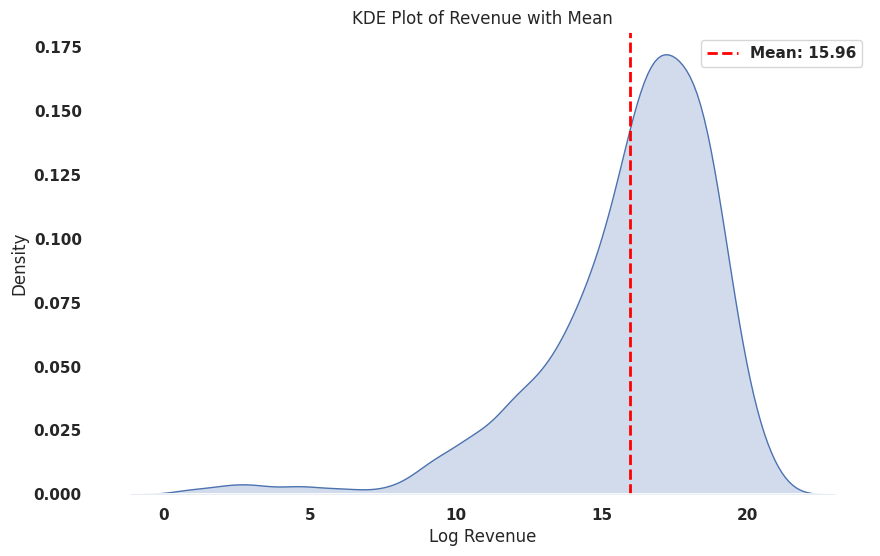

In [107]:
mean_revenue = train['log_revenue'].mean()
# Set up the plot
# sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
plt.figure(figsize=(10, 6))

# Plot the KDE for the 'revenue' column
sns.kdeplot(train['log_revenue'], shade=True)

# Add a vertical line at the mean
plt.axvline(mean_revenue, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_revenue:.2f}')

# Add labels and title
plt.title('KDE Plot of Revenue with Mean')
plt.xlabel('Log Revenue')
plt.ylabel('Density')
plt.legend()

# Show the plot
plt.show()

In [108]:
train = train[train['log_revenue'] > 5]

/tmp/ipykernel_33/2615132665.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train['log_revenue'], shade=True)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


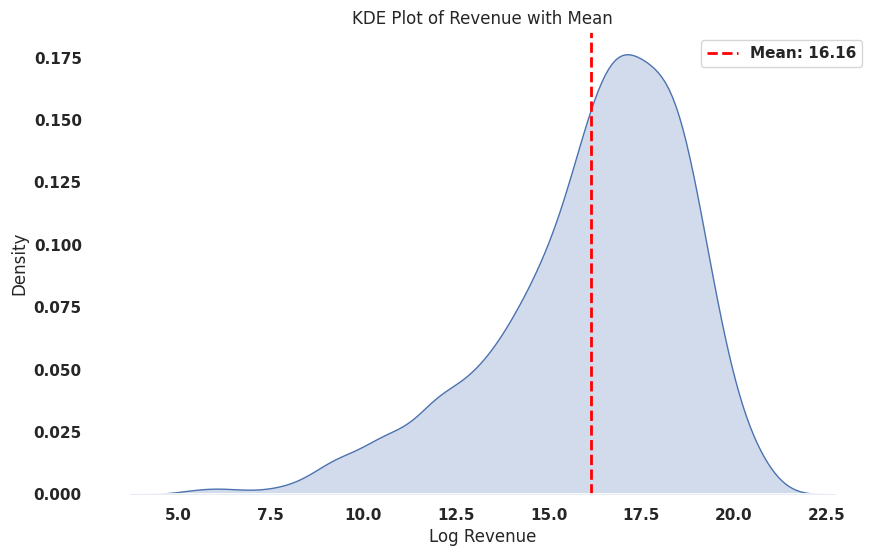

In [109]:
mean_revenue = train['log_revenue'].mean()
# Set up the plot
# sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
plt.figure(figsize=(10, 6))

# Plot the KDE for the 'revenue' column
sns.kdeplot(train['log_revenue'], shade=True)

# Add a vertical line at the mean
plt.axvline(mean_revenue, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_revenue:.2f}')

# Add labels and title
plt.title('KDE Plot of Revenue with Mean')
plt.xlabel('Log Revenue')
plt.ylabel('Density')
plt.legend()

# Show the plot
plt.show()

In [102]:
train['log_budget']=np.log1p(train['budget'])

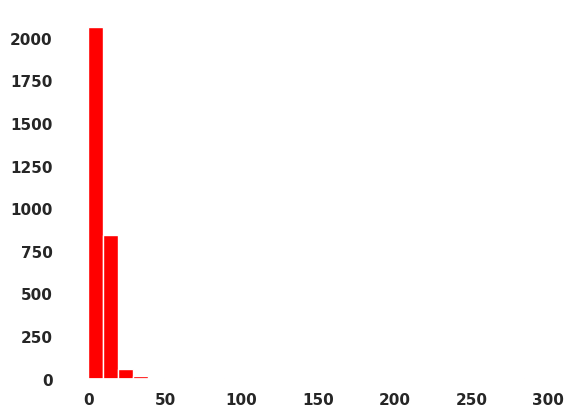

In [103]:
plt.hist(train['popularity'],bins=30,color='red')
plt.show()

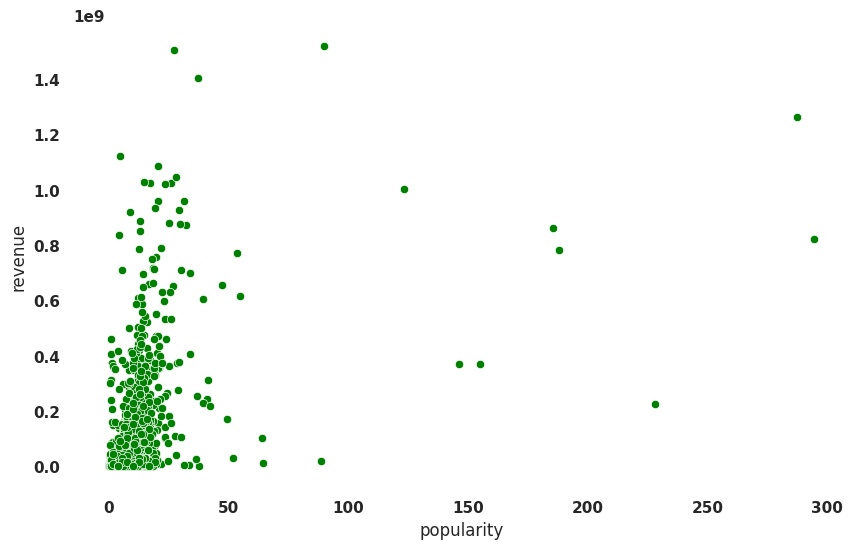

In [104]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=train['popularity'],y=train['revenue'],color='green')
plt.show()

## Splitting date, into day, month and year

/tmp/ipykernel_33/3832058083.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train['release_date'] = pd.to_datetime(train['release_date'])


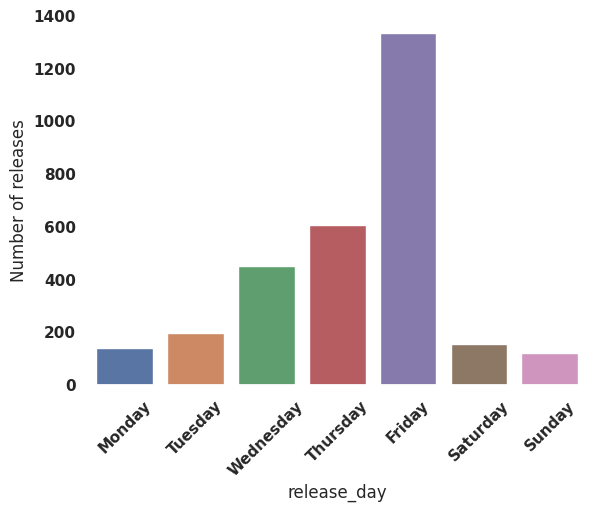

In [57]:

from datetime import datetime


# Function to correct the century in the year
def correct_century(date):
    if date.year < 1920:
        date = date.replace(year=date.year + 100)
    return date

# Assuming 'train' and 'test' DataFrames are predefined
# Fill missing values with a specific date and convert to datetime
train['release_date'] = train['release_date'].fillna('1990-01-01')
test['release_date'] = test['release_date'].fillna('1990-01-01')

# Convert the release_date columns to datetime
train['release_date'] = pd.to_datetime(train['release_date'])
test['release_date'] = pd.to_datetime(test['release_date'])

# Apply the century correction
train['release_date'] = train['release_date'].apply(correct_century)
test['release_date'] = test['release_date'].apply(correct_century)

# Extract day, month, and year
train['release_day'] = train['release_date'].apply(lambda x: x.weekday())
train['release_month'] = train['release_date'].apply(lambda x: x.month)
train['release_year'] = train['release_date'].apply(lambda x: x.year)

test['release_day'] = test['release_date'].apply(lambda x: x.weekday())
test['release_month'] = test['release_date'].apply(lambda x: x.month)
test['release_year'] = test['release_date'].apply(lambda x: x.year)

# Plot the number of releases by day of the week
day = train['release_day'].value_counts().sort_index()
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
sns.barplot(x=day.index, y=day.values)
plt.gca().set_xticklabels(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], rotation=45)
plt.ylabel('Number of releases')
plt.show()


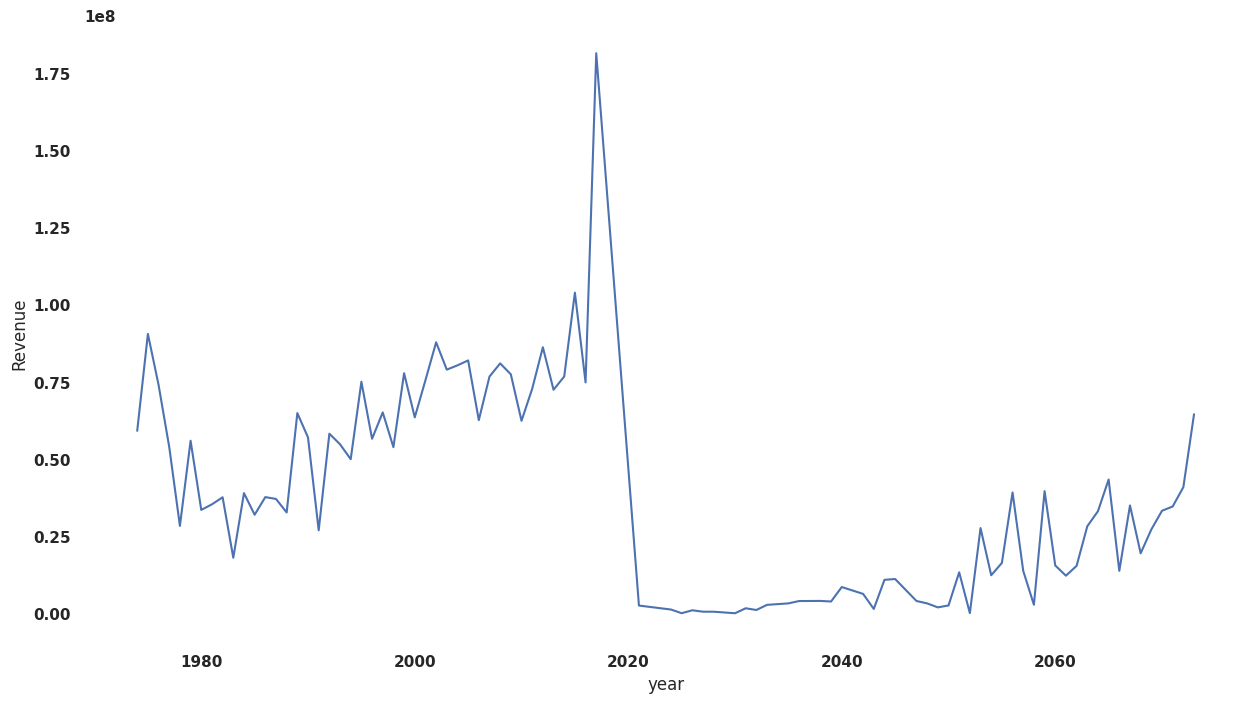

In [66]:
plt.figure(figsize=(15,8))
yearly=train.groupby(train['release_year'])['revenue'].agg('mean')
plt.plot(yearly.index,yearly)
plt.xlabel('year')
plt.ylabel("Revenue")
plt.savefig('fig')

In [100]:
train['popularity'].mean()

8.463274199666666

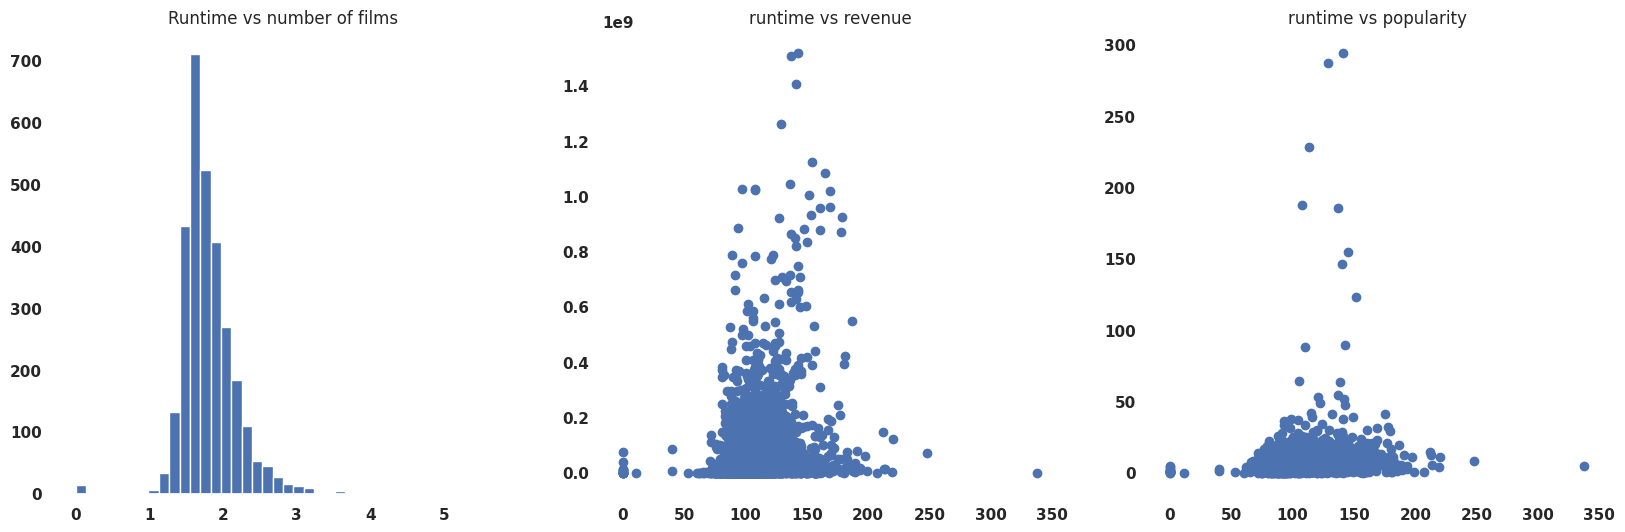

In [101]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.hist(train['runtime'].fillna(0) / 60, bins=40);
plt.title('Runtime vs number of films');
plt.subplot(1, 3, 2)
plt.scatter(train['runtime'].fillna(0), train['revenue'])
plt.title('runtime vs revenue');
plt.subplot(1, 3, 3)
plt.scatter(train['runtime'].fillna(0), train['popularity'])
plt.title('runtime vs popularity');

In [95]:
genres=train.loc[train['genres'].str.len()==1][['genres','revenue','budget','popularity','runtime']].reset_index(drop=True)
genres['genres']=genres.genres.apply(lambda x :x[0]['name'])

<Axes: xlabel='runtime', ylabel='genres'>

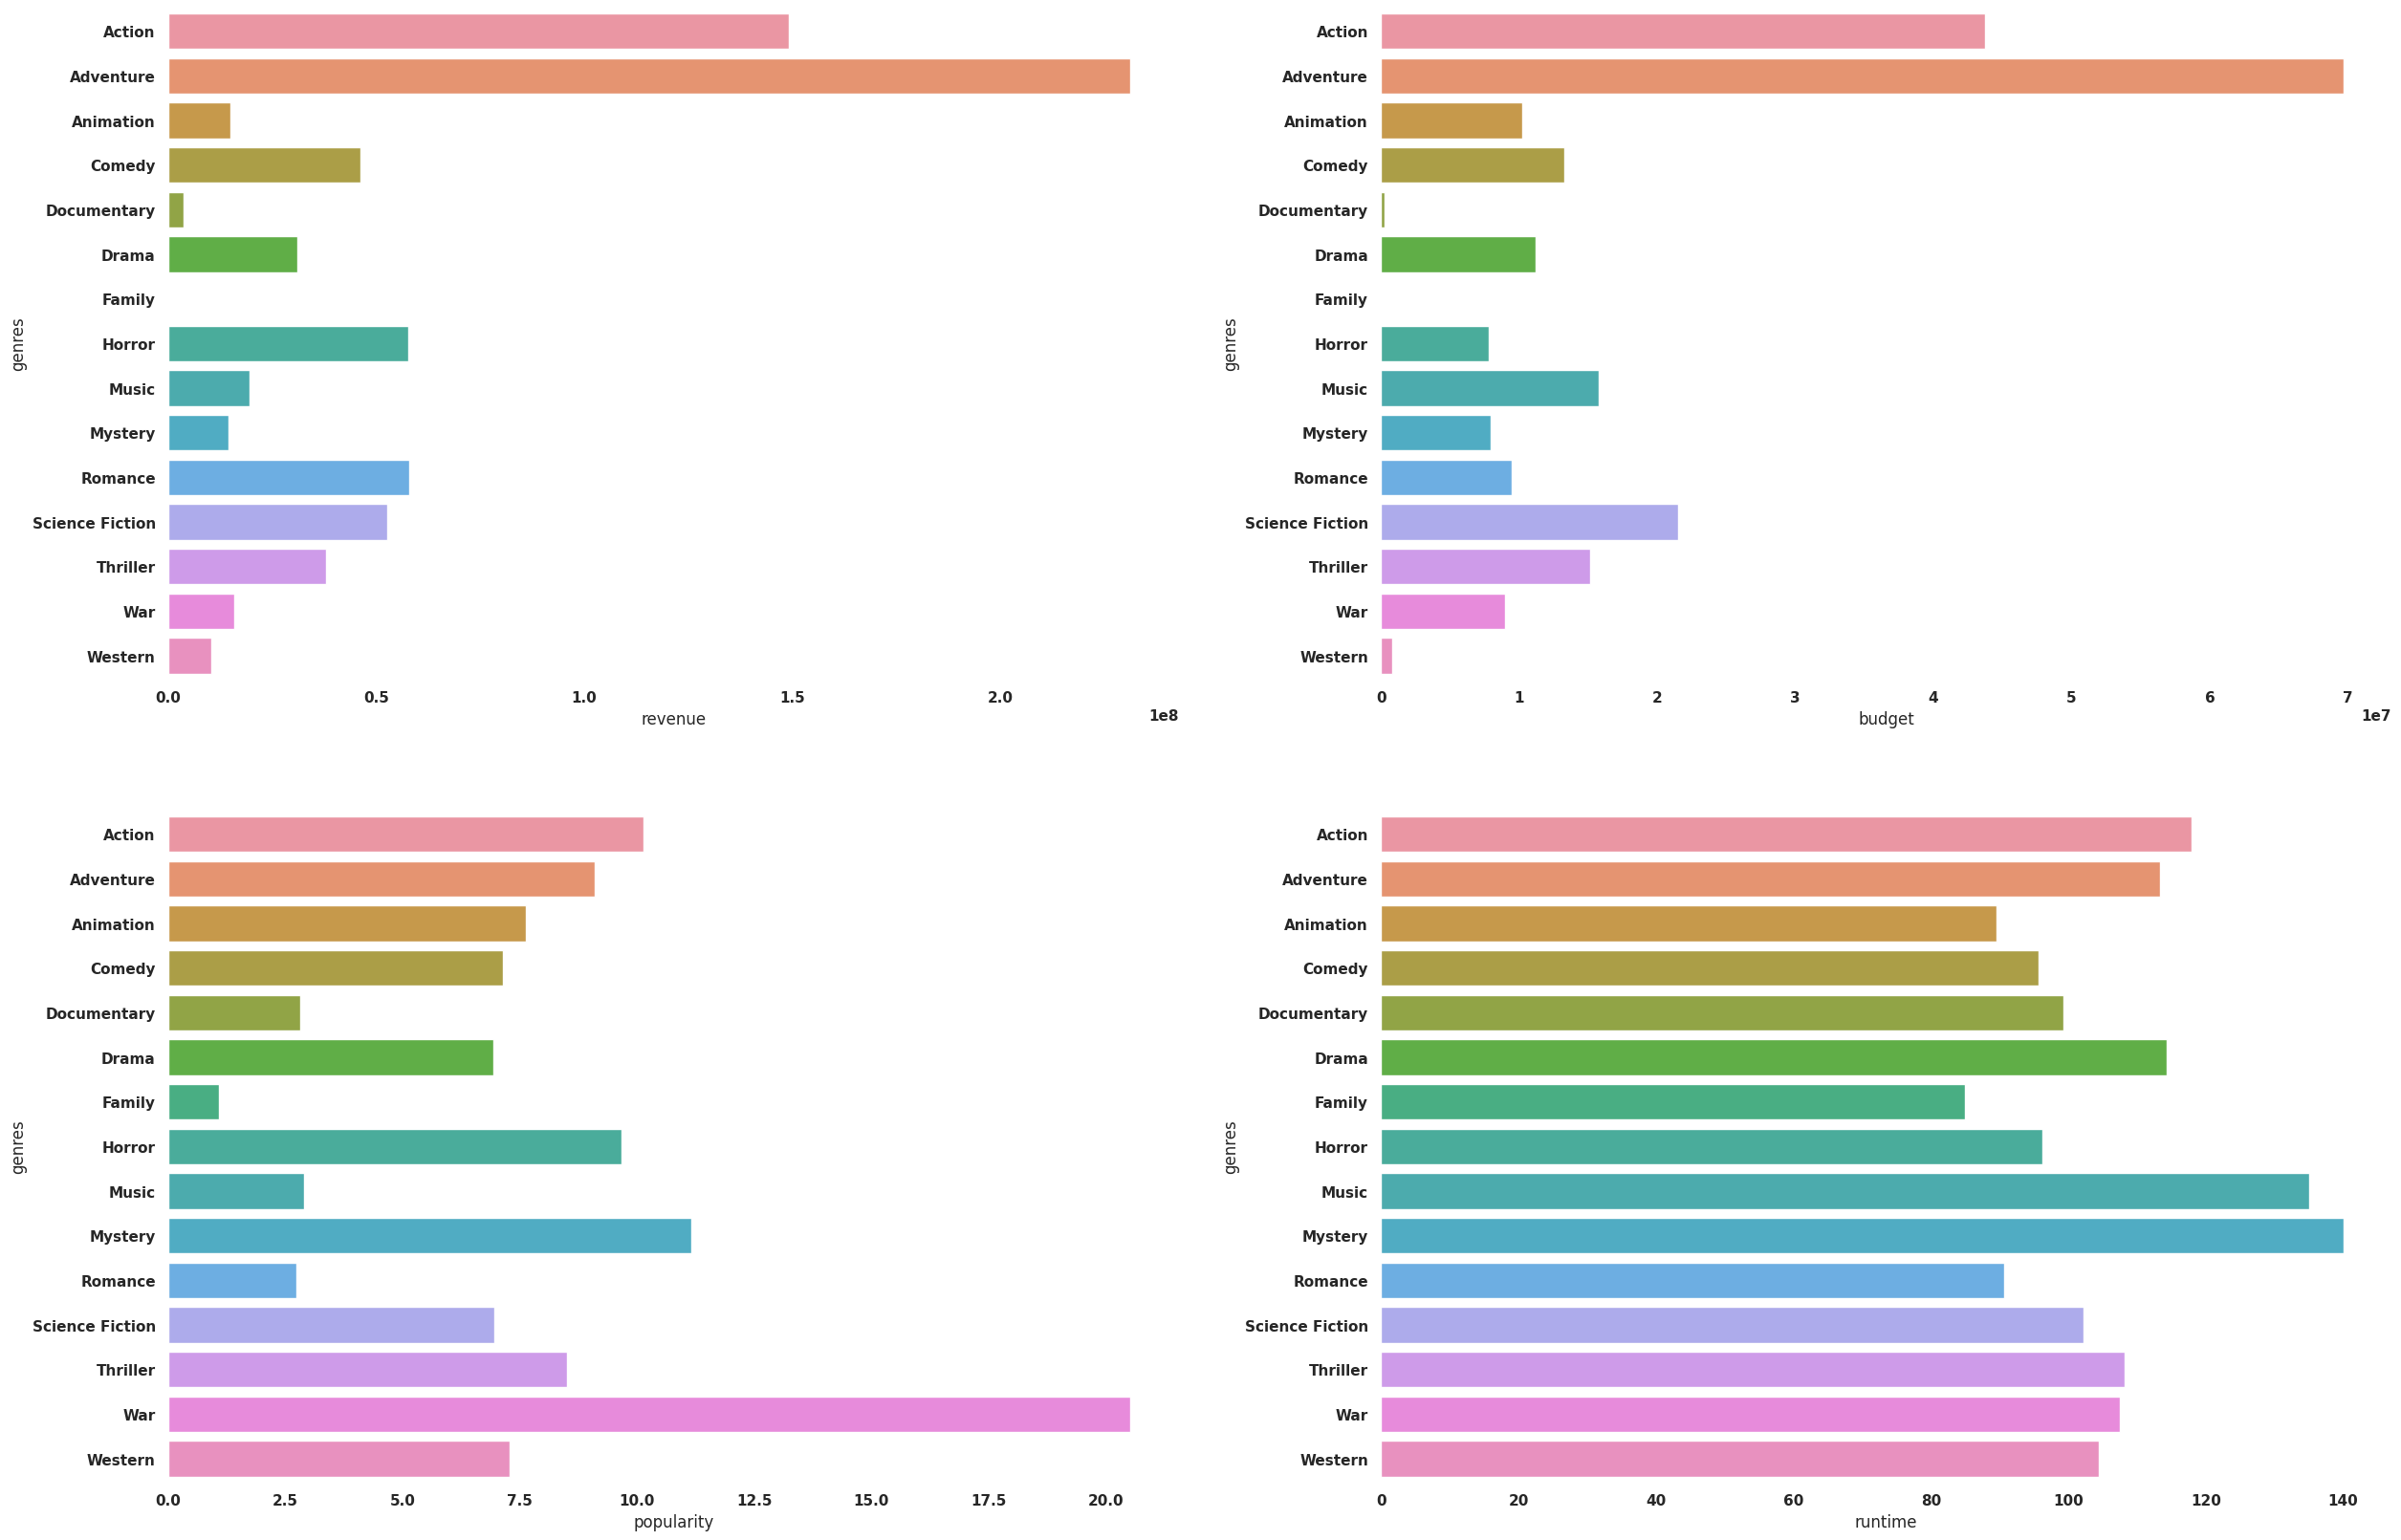

In [97]:

genres=genres.groupby(genres.genres).agg('mean')
plt.figure(figsize=(30,20))
plt.subplot(2,2,1)
sns.barplot(x= genres['revenue'],y=genres.index)

plt.subplot(2,2,2)
sns.barplot(x=genres['budget'],y=genres.index)

plt.subplot(2,2,3)
sns.barplot(x=genres['popularity'],y=genres.index)

plt.subplot(2,2,4)
sns.barplot(x=genres['runtime'],y=genres.index)